# Transfer Learning to Observed Data

Copyright © 2023 State of California, Department of Water Resources. University of California, Davis. All Rights Reserved. 

This script is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. 

Reproduction or distribution of this script without permission is prohibited. 

Contact: Zhaojun Bai (zbai@ucdavis.edu); Kevin He (kevin.he@water.ca.gov)

## Define hyper-parameters

In [ ]:
####################################################
############## Hyper-param definitions #############
####################################################
''' 
Select NN architecture from:
MLP, LSTM, GRU, ResNet, Residual_LSTM, Residual_GRU, Transformer
'''
model_type ='Residual_LSTM'

''' 
Name of pre-trained models (to be transferred)
'''
pretrain_model_path_prefix='mtl_i118_residual_lstm_8_2_Tune_RSAC_RSAN'

''' 
Numbers of neurons in the main branch
 - Provide two numbers for MLP, ResNet, Res-LSTM, Res-GRU, 
 - Provide one number for LSTM, GRU.
 '''
num_neurons_multiplier = [8,2]

'''
Number of training epochs (Note: training will stop when reaching this number 
or test loss doesn't decrease for 50 epochs)
'''
epochs = 1

''' 
Whether to (True) train models from scratch or (False) evaluate pre-trained models
'''
train_models = False

''' 
Whether to augment inputs (jittering and dropout)
'''
augmentation = False

''' 
Training and test set, in years
'''
calib_slice = slice('2000', '2016')
valid_slice = slice('2017', '2020')

''' 
Learning rate multiplier
Defined as ratio of learning rate between front layers and output layer
'''
lr_mult=0.1

''' 
Model resolution
- '1D': daily
- '1h': hourly
'''
interval = '1D'

''' 
Salinity forecasting lead time, unit is given by 'interval'
'''
lead_time = 0

####################################################
########## End of hyper-param definitions ##########
####################################################

import re

lead_freq = re.split('(\d+)',interval)[-1]

if lead_time > 0:
    forecast_marker = '_forecast_%dx%s' % (lead_time,interval)
else:
    forecast_marker = ''

model_type = model_type.lower()
assert (model_type in pretrain_model_path_prefix) or (model_type=='mlp' and 'd' in pretrain_model_path_prefix) or (model_type=='gru' and 'g' in pretrain_model_path_prefix)
import os
import sys
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt


given_name = '%s%s%s_hist' % (model_type, (('_'+interval) if interval.lower() != '1d' else ''), forecast_marker)



if augmentation:
    noise_sigma=0.03
    dropout_ratio = 0.05
else:
    noise_sigma=0.
    dropout_ratio = 0.

group_stations = False
initial_lr = 0.001
data_file = "observed_data_daily.xlsx"

print('Dataset: %s' % data_file)

google_drive_dir = 'DWR_Workshop'
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
gdrive_root_path = os.path.join('/content/drive','My Drive',google_drive_dir)
data_path = os.path.join(gdrive_root_path,data_file)
num_sheets = {"observed_data_daily.xlsx":9,
              "observed_data_hourly.xlsx":9}
sys.path.append(gdrive_root_path)


'''
Define parameters for input pre-processing
- ndays: number of daily values in inputs
- window_size: length of averaging windows
- nwindows: number of moving averages
'''
if model_type =='mlp':
    # apply pre-defined average windowing:
    ndays=8
    window_size=11
    nwindows=10
else:
    # directly use daily measurements as inputs
    ndays=118
    window_size=0
    nwindows=0

# percentile thresholds for ranged results
percentiles = [0,0.75,0.95]  
model_size = 'x'.join([str(n) for n in num_neurons_multiplier if n > 0])

Dataset: observed_data_daily.xlsx
Mounted at /content/drive


## Install Packages

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras import layers
#import keras
from collections import defaultdict
import joblib
import time

!pip install tensorflow-addons
import tensorflow_addons as tfa

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Read Data

In [ ]:
dflist = [pd.read_excel(data_path,i,index_col=0,parse_dates=True) for i in range(num_sheets[data_file])]
def load_data(data_file):
    if data_file in ["dsm2_ann_observed_1h.xlsx","dsm2_ann_observed_15min.xlsx"]:
        dfouts=dflist[-1]
        df2 = pd.pivot_table(dfouts, index=dfouts.index.date, columns=dfouts.index.hour)
        df2.columns=df2.columns.get_level_values(0)
        output_col_list = df2.columns
        df_inpout = pd.concat(dflist[0:(num_sheets[data_file]-1)]+[df2],axis=1).dropna(axis=0)
        dfinps = df_inpout.loc[:,~df_inpout.columns.isin(output_col_list)]
        dfouts = df_inpout.loc[:,df_inpout.columns.isin(output_col_list)]
    else:
        df_inpout = pd.concat(dflist[0:(num_sheets[data_file])],axis=1).dropna(axis=0)
        dfinps = df_inpout.loc[:,~df_inpout.columns.isin(dflist[num_sheets[data_file]-1].columns)]
        dfouts = df_inpout.loc[:,df_inpout.columns.isin(dflist[num_sheets[data_file]-1].columns)]
    return dfinps, dfouts

dfinps, dfouts = load_data(data_file)
dfinps.head()

,northern_flow,sjr_flow,exports,/HIST+GATE/RSAC128/POS/01JAN1953 - 01JAN2020/IR-YEAR/DWR-DMS-DSM2/,div+seep-drain_dcd+smcd,daily_max-min,sjr_vernalis_ec,sac_greens_ec
2000-01-01,14954.0,1581.0,10535.7,1.0,2069.44,5.1,829.6,167.08
2000-01-02,14928.0,1581.0,10489.3,1.0,2104.34,5.4,824.5,164.17
2000-01-03,14998.0,1581.0,10557.0,1.0,2092.58,5.7,819.4,169.58
2000-01-04,14746.0,1631.0,10639.4,1.0,2077.37,5.9,814.2,166.67
2000-01-05,14681.0,1674.0,10758.0,1.0,2035.92,6.1,809.1,170.00


In [ ]:
dfouts

,CHDMC006,CHSWP003,CHVCT000,OLD_MID,ROLD024,ROLD059,RSAC064,RSAC075,RSAC081,RSAC092,...,RSAN037,RSAN058,RSAN072,RSMKL008,SLCBN002,SLDUT007,SLMZU011,SLMZU025,SLSUS012,SLTRM004
2000-01-01,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000
2000-01-02,530.885417,-2.000000,-2.000000,899.968750,-2.000000,-2.000000,15525.515625,7169.864130,-2.000000,410.656250,...,-2.000000,-2.000000,-2.000000,175.750000,-2.000000,-2.000000,9546.875000,-2.000000,-2.000000,-2.000000
2000-01-03,560.114584,-2.000000,-2.000000,892.083333,-2.000000,-2.000000,15375.697917,6549.184783,3492.006250,374.010416,...,-2.000000,-2.000000,-2.000000,171.531250,-2.000000,-2.000000,9502.604167,-2.000000,-2.000000,-2.000000
2000-01-04,501.718750,-2.000000,-2.000000,906.427083,-2.000000,-2.000000,15423.510417,6601.141304,3354.670168,469.680000,...,-2.000000,-2.000000,-2.000000,167.864583,-2.000000,-2.000000,9641.875000,-2.000000,-2.000000,-2.000000
2000-01-05,491.854167,-2.000000,-2.000000,878.958333,-2.000000,-2.000000,15907.562500,7710.029771,3649.512816,430.270833,...,-2.000000,-2.000000,-2.000000,176.385417,-2.000000,-2.000000,9831.770833,-2.000000,-2.000000,-2.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,455.062500,416.286458,332.854167,639.083333,427.833333,687.468750,10791.906250,5826.927083,2418.104167,310.302083,...,345.864583,602.968750,634.364583,196.270833,8121.322917,610.854167,8447.697917,6019.458333,7720.145833,462.604167
2019-12-28,472.354167,428.161458,335.770833,656.750000,443.270833,697.718750,10060.083333,5117.729167,1991.656250,307.802083,...,341.500000,644.770833,648.114583,196.000000,7770.479167,606.697917,8405.416667,5926.854167,7621.979167,443.364583
2019-12-29,483.083333,438.223958,342.291667,652.552083,439.927083,718.250000,9644.697917,4882.864583,1830.187500,308.885417,...,339.135417,650.885417,664.062500,191.656250,7905.635417,601.197917,8397.437500,5802.781250,7538.031250,424.979167
2019-12-30,480.906250,434.765625,347.927083,631.729167,446.635417,735.562500,9643.729167,4832.671264,1883.322917,272.500000,...,335.510417,632.385417,661.187500,188.864583,6706.145833,598.166667,8325.843750,5637.583333,7326.812500,424.218750


In [ ]:
output_locations_w_duplicates_for_time = dfouts.columns[~dfouts.columns.str.contains('_dup')]
output_locations = set(output_locations_w_duplicates_for_time)
print('Found %d stations' % len(output_locations))

station_orders = {s:ii for ii, s in enumerate(sorted(output_locations))}

Found 23 stations


## Model Definitions

In [ ]:
"""# Custom loss function"""
def mse_loss_masked(y_true, y_pred):
    squared_diff = tf.reduce_sum(tf.math.squared_difference(y_pred[y_true>=0],y_true[y_true>=0]))
    return squared_diff/(tf.reduce_sum(tf.cast(y_true>=0, tf.float32))+0.01)

# Define Sequential model
# LSTM model has one LSTM layer
# MLP model has 3 Dense layers
NFEATURES = (ndays + nwindows) * (num_sheets[data_file]-1)

def build_lstm_model(lstm_units=8,lstm_units2=None, output_shape=1, act_func='sigmoid',layer_type='lstm'):
    rnn_layer = layers.LSTM if layer_type == 'lstm' else layers.GRU
    model = keras.Sequential(
        [
            layers.Input(shape=(NFEATURES)),
            layers.Reshape((ndays+nwindows,num_sheets[data_file]-1)),
            layers.Permute((2,1)),
            rnn_layer(units = lstm_units, activation=act_func,return_sequences=True),
            # rnn_layer(units = lstm_units, activation=act_func),
            layers.Flatten(),
            layers.Dense(output_shape, activation=keras.activations.linear,name='output')
        ])
    model.compile(optimizer=keras.optimizers.Adam(
        learning_rate=initial_lr), loss=mse_loss_masked)
    return model

def build_residual_lstm_model(nhidden1=8, nhidden2=2, output_shape=1, act_func='sigmoid',layer_type='lstm',conv_init=None):
    rnn_layer = layers.LSTM if layer_type == 'lstm' else layers.GRU
    inputs = layers.Input(shape=NFEATURES)
    x = layers.Reshape((ndays+nwindows,num_sheets[data_file]-1))(inputs)
    x = layers.Permute((2,1))(x)

    y = tf.keras.layers.Conv1D(8+10,1, activation='relu',
                            kernel_initializer=conv_init,
                            kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0, l2=0),
                            trainable=False)(x)

    y = layers.Flatten()(y)
    y = layers.Dense(nhidden1, activation=act_func)(y)
    y = layers.Dense(nhidden2, activation=act_func)(y)
    y = layers.Dense(output_shape, activation=keras.activations.linear,name='mlp_output')(y)

    shortcut = x
    shortcut = layers.Dense(nhidden1, activation=act_func)(shortcut)
    shortcut = rnn_layer(units = output_shape*2, activation=act_func,return_sequences=True)(shortcut)
    shortcut = layers.Flatten()(shortcut)
    shortcut = layers.Dense(output_shape, activation=keras.activations.linear,name='lstm_output')(shortcut)

    outputs = layers.Add(name="res_add")([y, shortcut])
    # outputs = layers.Activation("relu",name="res_relu")(outputs)
    outputs = layers.LeakyReLU(alpha=0.3,name="res_relu")(outputs)
    
    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=keras.optimizers.Adam(
        learning_rate=initial_lr), loss=mse_loss_masked)
    return model



def build_model(nhidden1=8, nhidden2=2, output_shape=1, act_func='sigmoid'):
    model = keras.Sequential(
        [
            layers.Input(shape=(NFEATURES)),
            layers.Dense(nhidden1, activation=act_func),
            layers.Dense(nhidden2, activation=act_func),
            layers.Dense(output_shape, activation=keras.activations.linear,name='output')
        ])
    model.compile(optimizer=keras.optimizers.Adam(
        learning_rate=initial_lr), loss=mse_loss_masked)
    #model.compile(optimizer=keras.optimizers.RMSprop(), loss=mse_loss_masked)
    return model

def build_resnet_model(nhidden1=8, nhidden2=2, output_shape=1, act_func='sigmoid',filters=num_sheets[data_file]-1, kernel_size=3, stride=1):
    inputs = layers.Input(shape=NFEATURES)
    x = layers.Reshape((ndays+nwindows,num_sheets[data_file]-1))(inputs)

    y = layers.ZeroPadding1D(padding=1,name="padding_branch2a")(x)
    y = layers.Conv1D(filters,kernel_size,strides=stride,use_bias=False,
                                name="res_branch2a")(y)
    y = layers.BatchNormalization()(y)
    y = layers.Activation("relu", name="res_branch2a_relu")(y)

    y = layers.ZeroPadding1D(padding=1,name="padding_branch2b")(y)
    y = layers.Conv1D(filters,kernel_size,use_bias=False,
                            name="res_branch2b")(y)
    y = layers.BatchNormalization()(y)
    y = layers.Flatten()(y)
    y = layers.Dense(nhidden1, activation=act_func)(y)

    shortcut = inputs
    shortcut = layers.Dense(nhidden1, activation=act_func)(shortcut)

    y = layers.Add(name="res")([y, shortcut])
    
    y = layers.Activation("relu",name="res_relu")(y)


    y = layers.Dense(nhidden2, activation=act_func)(y)
    outputs= layers.Dense(output_shape, activation=keras.activations.linear,name='output')(y)

    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=keras.optimizers.Adam(
        learning_rate=initial_lr), loss=mse_loss_masked)
    return model

## Evaluation Metrics

In [ ]:
eval_metrics = ['MSE', 'Bias', 'R', 'RMSD', 'NSE']
key_stations = ['RSAC064','CCWD_Rock','CHDMC006', 'CHSWP003','RSAC092','RSAN018']

def evaluate_sequences(target, pred, metrics):
    assert len(target) == len(pred), 'Target and predicted sequence length must equal.'
    if len(target.shape)==1 or target.shape[-1]==1:                                     
        valid_entries = target>=0
    else:
        valid_entries = (target>=0).all(axis=1)
    sequence_length = np.sum(valid_entries)
    if np.any(sequence_length == 0):
        return {k: 0 for k in metrics}
    target=target[valid_entries]
    pred = pred[valid_entries]
    SD_pred = np.sqrt( np.sum((pred-np.mean(pred)) ** 2) /(sequence_length-1))
    SD_target = np.sqrt( np.sum((target-np.mean(target)) ** 2) /(sequence_length-1))

    eval_results = defaultdict(float)
    
    for m in metrics:
        if m =='MSE':
            eval_results[m] = ((target - pred)**2).mean()
        elif m =='Bias':
            eval_results[m] = np.sum(pred - target)/np.sum(target) * 100
        elif m == 'R':
            eval_results[m] = np.sum(np.abs((pred-np.mean(pred)) * (target - np.mean(target)))) / (sequence_length * SD_pred * SD_target)
        elif m == 'RMSD':
            eval_results[m] = np.sqrt(np.sum( ( ( pred-np.mean(pred) ) * ( target - np.mean(target) ) ) ** 2 ) / sequence_length)
        elif m == 'NSE':
            eval_results[m] = 1 - np.sum( ( target - pred ) ** 2 ) / np.sum( (target - np.mean(target) ) ** 2 )
    return eval_results

In [ ]:
import annutils
result_folders = ['models','results','images']
for result_folder in result_folders:
    if not os.path.exists(os.path.join(gdrive_root_path, result_folder)):
        os.makedirs(os.path.join(gdrive_root_path, result_folder))

In [ ]:
station_without_groups = {'all':output_locations}
station_with_groups = {'G1':['SSS','RSAC101','RSMKL008'],
                  'G2':['Old_River_Hwy_4','Middle_River_Intake','CCWD_Rock','SLTRM004','RSAN032','RSAN037','SLDUT007','ROLD024','RSAN058','RSAN072','OLD_MID','ROLD059','CHDMC006','CHSWP003','CHVCT000'],
                  'G3':['SLCBN002','SLSUS012','SLMZU011','SLMZU025','RSAC064','RSAC075','RSAC081','RSAN007','RSAC092','RSAN018','Martinez']}
final_groups = {False: station_without_groups, 
                True: station_with_groups}

## Load Pre-Trained Models and Apply Transfer Learning

In [ ]:
for group_name, stations in final_groups[group_stations].items():
    if not train_models:
        break
    selected_output_variables = []
    for station in stations:
        for output in output_locations:
            if station in output:
                selected_output_variables.append(output)
    # 1: add here!
    selected_output_variables = [x for x in sorted(selected_output_variables, key=lambda s: station_orders[s.split('-')[0]],reverse=False)]


    print('Training MTL ANN for %d stations: ' % len(selected_output_variables))
    print([station.replace('target/','').replace('target','') for station in selected_output_variables])
    

    # create tuple of calibration and validation sets and the xscaler and yscaler on the combined inputs
    (xallc, yallc), (xallv, yallv), xscaler, yscaler = \
        annutils.create_training_sets([dfinps],
                                      [dfouts[selected_output_variables]],
                                      #train_frac=train_frac,
                                      calib_slice=calib_slice,
                                      valid_slice=valid_slice,
                                      ndays=ndays,window_size=window_size,nwindows=nwindows,
                                      noise_sigma=noise_sigma,dropout_ratio=dropout_ratio,
                                      lead_time=lead_time,lead_freq=lead_freq)
    if pretrain_model_path_prefix is not None and len(pretrain_model_path_prefix) > 0:
        try:
            loaded_model = annutils.load_model(os.path.join(gdrive_root_path,'models', pretrain_model_path_prefix),custom_objects={"mse_loss_masked": mse_loss_masked})
            pretrained_model = loaded_model.model
            print('Ignored defined model arc and loaded pre-trained model from %s.h5' % os.path.join(gdrive_root_path,'models', pretrain_model_path_prefix))
        except:
            # only model weights are saved, build model then load
            if model_type.lower() in ['lstm','gru']:
                pretrained_model = build_lstm_model(num_neurons_multiplier[0]*len(output_locations),
                                                    num_neurons_multiplier[1]*len(output_locations),
                                                    output_shape=yallc.shape[1],
                                                    act_func='sigmoid',
                                                    layer_type=model_type.lower())
            elif model_type.lower() == 'mlp':
                pretrained_model = build_model(num_neurons_multiplier[0]*len(output_locations),
                                               num_neurons_multiplier[1]*len(output_locations),
                                               output_shape=yallc.shape[1], act_func='sigmoid')
            elif model_type.lower() =='resnet':
                pretrained_model = build_resnet_model(num_neurons_multiplier[0]*len(output_locations),
                                                      num_neurons_multiplier[1]*len(output_locations),
                                                      output_shape=yallc.shape[1], act_func='sigmoid')
        
            pretrained_model.load_weights(os.path.join(gdrive_root_path,'models', pretrain_model_path_prefix+'.h5'))
            print("Built %s model and loaded weights" % model_type)
        print('Transfer learning from pre-trained model %s' % os.path.join(gdrive_root_path,'models', pretrain_model_path_prefix))
        o = keras.layers.Dense(yallc.shape[1], activation='linear',name='transfer_out')(pretrained_model.layers[-2].output)
        model = keras.Model(inputs=pretrained_model.input, outputs=[o])

        
        optimizers = [
            tf.keras.optimizers.Adam(learning_rate=lr_mult*initial_lr),
            tf.keras.optimizers.Adam(learning_rate=initial_lr)
        ]
        optimizers_and_layers = [(optimizers[0], model.layers[0:-1]), (optimizers[1], model.layers[-1])]

        model.compile(optimizer=tfa.optimizers.MultiOptimizer(optimizers_and_layers),
                      loss=mse_loss_masked)
    elif model_type.lower() in ['lstm','gru']:
        model = build_lstm_model(num_neurons_multiplier[0]*len(output_locations),
                                 num_neurons_multiplier[1]*len(output_locations),
                                 output_shape=yallc.shape[1],
                                 act_func='sigmoid',
                                 layer_type=model_type.lower())
        print("No pre-trained model found, built %s model and loaded weights" % model_type)
    elif model_type.lower() == 'mlp':
        model = build_model(num_neurons_multiplier[0]*len(output_locations),
                            num_neurons_multiplier[1]*len(output_locations),
                            output_shape=yallc.shape[1], act_func='sigmoid')
        print("No pre-trained model found, built %s model and loaded weights" % model_type)
    elif model_type.lower() =='resnet':
        model = build_resnet_model(num_neurons_multiplier[0]*len(output_locations),
                                   num_neurons_multiplier[1]*len(output_locations),
                                   output_shape=yallc.shape[1], act_func='sigmoid')
        print("No pre-trained model found, built %s model and loaded weights" % model_type)
    elif model_type.lower() in ['res-lstm','res-gru']:
        conv_init = tf.constant_initializer(annutils.conv_filter_generator(ndays=8,window_size=11,nwindows=10))

        model = build_residual_lstm_model(num_neurons_multiplier[0]*len(output_locations),
                                 num_neurons_multiplier[1]*len(output_locations),
                                 output_shape=yallc.shape[1],
                                 act_func='sigmoid',
                                 layer_type=model_type.lower()[len('res-'):],
                                 conv_init=conv_init)
        print("No pre-trained model found, built %s model and loaded weights" % model_type)

    display(model.summary())
    start_time = time.time()
    history = model.fit(
        xallc,
        yallc,
        epochs=epochs,
        batch_size=128,
        validation_data=(xallv, yallv),
        callbacks=[
            keras.callbacks.EarlyStopping(
                monitor="val_loss", patience=50, mode="min", restore_best_weights=True),
        ],
        verbose=0,
    )
    end_time=time.time()
    print('Training time: %d min' % ((end_time-start_time)/60) )
    model_save_path = os.path.join(gdrive_root_path, 'models', (('lr_mult_%s_%s_transfer_'% (str(lr_mult),pretrain_model_path_prefix)) if pretrain_model_path_prefix else '')+given_name)
    if pretrain_model_path_prefix is not None and len(pretrain_model_path_prefix) > 0:
        joblib.dump((xscaler,yscaler),'%s_xyscaler.dump'%model_save_path)
        model.save_weights('%s.h5'%model_save_path)
    else:
        annutils.save_model(model_save_path, model, xscaler, yscaler)
    print('Model saved at %s.h5' % model_save_path)

# Evaluation

## Numerical Results

In [ ]:
full_results={}
range_results=defaultdict(defaultdict)

df_inpout = pd.concat(dflist[0:(num_sheets[data_file])],axis=1).dropna(axis=0)
for group_name, stations in final_groups[group_stations].items():
    # prepare dataset
    selected_output_variables = []
    for station in stations:
        for output in output_locations:
            if station in output:
                selected_output_variables.append(output)
    # 2: add here!
    selected_output_variables = [x for x in sorted(selected_output_variables, key=lambda s: station_orders[s.split('-')[0]],reverse=False)]

    print('Testing MTL ANN for %d stations: ' % len(selected_output_variables))

    print([station.replace('target/','').replace('target','') for station in selected_output_variables])

    model_save_path = os.path.join(gdrive_root_path, 'models', (('lr_mult_%s_%s_transfer_'% (str(lr_mult),pretrain_model_path_prefix)) if pretrain_model_path_prefix else '')+given_name)

    # create tuple of calibration and validation sets and the xscaler and yscaler on the combined inputs
    (xallc, yallc), (xallv, yallv), xscaler, yscaler = \
        annutils.create_training_sets([dfinps],
                                      [dfouts[selected_output_variables]],
                                      #train_frac=train_frac,
                                      calib_slice=calib_slice,
                                      valid_slice=valid_slice,
                                      ndays=ndays,window_size=window_size,nwindows=nwindows,
                                      lead_time=lead_time,lead_freq=lead_freq)
    try:
        annmodel = annutils.load_model(model_save_path,
                                       custom_objects={"mse_loss_masked": mse_loss_masked})
        model = annmodel.model
    except:
        print('Unable to load saved model, rebuilding from pre-trained model...')
        if pretrain_model_path_prefix is not None and len(pretrain_model_path_prefix) > 0:
            try:
                loaded_model = annutils.load_model(os.path.join(gdrive_root_path,'models', pretrain_model_path_prefix),custom_objects={"mse_loss_masked": mse_loss_masked})
                pretrained_model = loaded_model.model
                print('Ignored defined model arc and loaded pre-trained model from %s.h5' % os.path.join(gdrive_root_path,'models', pretrain_model_path_prefix))
            except:
                # only model weights are saved, build model then load
                if model_type.lower() in ['lstm','gru']:
                    pretrained_model = build_lstm_model(num_neurons_multiplier[0]*len(output_locations),
                                                        num_neurons_multiplier[1]*len(output_locations),
                                                        output_shape=yallc.shape[1],
                                                        act_func='sigmoid',
                                                        layer_type=model_type.lower())
                elif model_type.lower() == 'mlp':
                    pretrained_model = build_model(num_neurons_multiplier[0]*len(output_locations),
                                                   num_neurons_multiplier[1]*len(output_locations),
                                                   output_shape=yallc.shape[1], act_func='sigmoid')
                elif model_type.lower() =='resnet':
                    pretrained_model = build_resnet_model(num_neurons_multiplier[0]*len(output_locations), 
                                                          num_neurons_multiplier[1]*len(output_locations),
                                                          output_shape=yallc.shape[1], act_func='sigmoid')
            
            # remove last layer and attach new
            o = keras.layers.Dense(yallc.shape[1], activation='linear',name='transfer_out')(pretrained_model.layers[-2].output)
            model = keras.Model(inputs=pretrained_model.input, outputs=[o])

        model.load_weights(model_save_path+'.h5')
        print('Loaded model weights from %s.h5' % model_save_path)
        xscaler,yscaler=joblib.load('%s_xyscaler.dump'%model_save_path)


    train_pred = pd.DataFrame(np.clip(model.predict(xallc),0,1),yallc.index,columns=yallc.columns)
    test_pred = pd.DataFrame(np.clip(model.predict(xallv),0,1),yallv.index,columns=yallv.columns)

    for ii, location in enumerate(selected_output_variables):
        
        # compute training results
        train_results = evaluate_sequences(yallc.loc[:,location].to_numpy().reshape(-1,1),
                                           train_pred.loc[:,location].to_numpy().reshape(-1,1),
                                           eval_metrics)
        train_results['R^2'] = r2_score(train_pred.loc[:,location].to_numpy().reshape(-1,1),
                                        yallc.loc[:,location].to_numpy().reshape(-1,1))
        full_results['%s_train' %location] = train_results

        # compute evaluation results
        eval_results = evaluate_sequences(yallv.loc[:,location].to_numpy().reshape(-1,1),
                                          test_pred.loc[:,location].to_numpy().reshape(-1,1),
                                          eval_metrics)
        eval_results['R^2'] = r2_score(test_pred.loc[:,location].to_numpy().reshape(-1,1),
                                       yallv.loc[:,location].to_numpy().reshape(-1,1))

        full_results['%s_test' %location] = eval_results

        all_target = np.concatenate((yallc[location].to_numpy().reshape(-1,1),
                                    yallv[location].to_numpy().reshape(-1,1)),axis=0)
        all_pred = np.concatenate((train_pred[location].to_numpy().reshape(-1,1),
                                    test_pred[location].to_numpy().reshape(-1,1)),axis=0)

        # compute results at different EC ranges
        for (lower_quantile, upper_quantile) in zip(percentiles,percentiles[1:]+[1,]):
            lower_threshold = np.quantile(all_target, lower_quantile)
            upper_threshold = np.quantile(all_target, upper_quantile)
            eval_results = evaluate_sequences(all_target[(all_target > lower_threshold) & (all_target <= upper_threshold)],
                                              all_pred[(all_target > lower_threshold) & (all_target <= upper_threshold)],
                                              eval_metrics)
            range_results[location][lower_quantile*100] = eval_results

Testing MTL ANN for 23 stations: 
['CHDMC006', 'CHSWP003', 'CHVCT000', 'OLD_MID', 'ROLD024', 'ROLD059', 'RSAC064', 'RSAC075', 'RSAC081', 'RSAC092', 'RSAN007', 'RSAN018', 'RSAN032', 'RSAN037', 'RSAN058', 'RSAN072', 'RSMKL008', 'SLCBN002', 'SLDUT007', 'SLMZU011', 'SLMZU025', 'SLSUS012', 'SLTRM004']
Unable to load saved model, rebuilding from pre-trained model...
Ignored defined model arc and loaded pre-trained model from /content/drive/My Drive/DWR_Workshop/models/mtl_i118_residual_lstm_8_2_Tune_RSAC_RSAN.h5
Loaded model weights from /content/drive/My Drive/DWR_Workshop/models/lr_mult_0.1_mtl_i118_residual_lstm_8_2_Tune_RSAC_RSAN_transfer_residual_lstm_hist.h5
35/35 [==============================] - 0s 12ms/step


In [ ]:
def add_subplot_axes(ax,rect,facecolor='w'): # matplotlib 2.0+
    fig = plt.gcf()
    box = ax.get_position()
    width = box.width
    height = box.height
    inax_position  = ax.transAxes.transform(rect[0:2])
    transFigure = fig.transFigure.inverted()
    infig_position = transFigure.transform(inax_position)    
    x = infig_position[0]
    y = infig_position[1]
    width *= rect[2]
    height *= rect[3]
    subax = fig.add_axes([x,y,width,height],facecolor=facecolor)  # matplotlib 2.0+
    x_labelsize = subax.get_xticklabels()[0].get_size()
    y_labelsize = subax.get_yticklabels()[0].get_size()
    x_labelsize *= rect[2]**0.5
    y_labelsize *= rect[3]**0.5
    subax.xaxis.set_tick_params(labelsize=x_labelsize)
    subax.yaxis.set_tick_params(labelsize=y_labelsize)
    return subax

## Generate Plots

### Time Series Plots

Testing MTL ANN for 23 stations: 
['CHDMC006', 'CHSWP003', 'CHVCT000', 'OLD_MID', 'ROLD024', 'ROLD059', 'RSAC064', 'RSAC075', 'RSAC081', 'RSAC092', 'RSAN007', 'RSAN018', 'RSAN032', 'RSAN037', 'RSAN058', 'RSAN072', 'RSMKL008', 'SLCBN002', 'SLDUT007', 'SLMZU011', 'SLMZU025', 'SLSUS012', 'SLTRM004']
Ignored defined model arc and loaded pre-trained model from /content/drive/My Drive/DWR_Workshop/models/mtl_i118_residual_lstm_8_2_Tune_RSAC_RSAN.h5
Loaded model weights from /content/drive/My Drive/DWR_Workshop/models/lr_mult_0.1_mtl_i118_residual_lstm_8_2_Tune_RSAC_RSAN_transfer_residual_lstm_hist.h5
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 944)]        0           []                               
                                                                                    

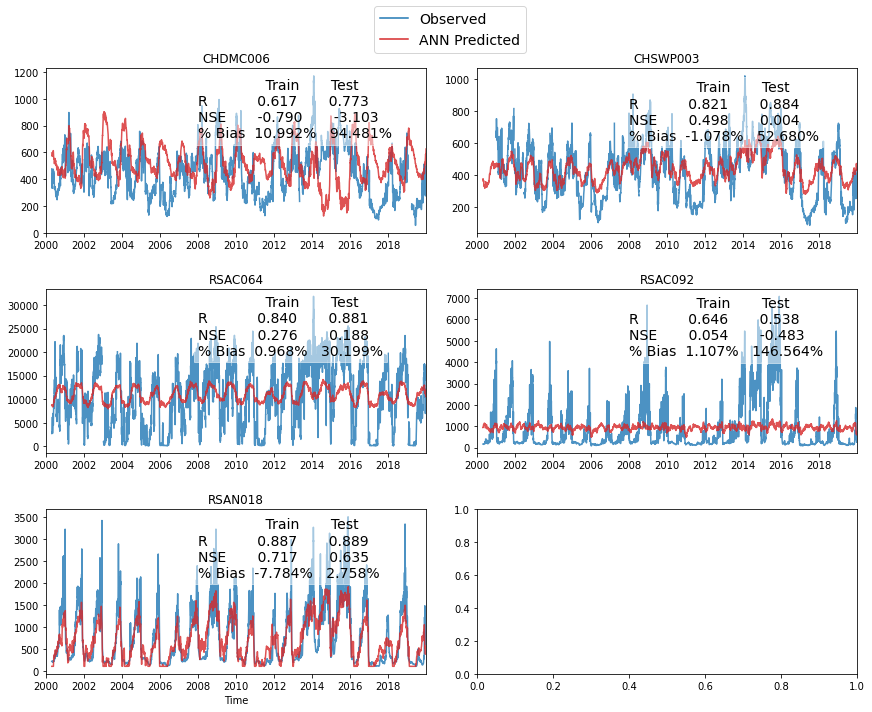

In [ ]:
from matplotlib import ticker
import matplotlib.dates as mdates
from matplotlib.lines import Line2D

key_station_mappings = {'CCWD Rock': 'RSL',
                        'Middle River Intake':'MUP',
                        'Old River Hwy 4': 'OH4',
                        'OLD MID':'OLD_MID'}

ncols=2
fig_combined_timeseries, ax_combined_timeseries = plt.subplots(nrows=len(key_stations)//ncols,
                                                               ncols=ncols,
                                                               figsize=(6*ncols,3*len(key_stations)//ncols))
fig_combined_timeseries.tight_layout(h_pad=3.5, w_pad=2)
ii = 0
for group_name, stations in final_groups[group_stations].items():
    # prepare dataset
    selected_output_variables = []
    for station in stations:
        for output in output_locations:
            if station in output:
                selected_output_variables.append(output)
    # 3: add here!
    selected_output_variables = [x for x in sorted(selected_output_variables, key=lambda s: station_orders[s.split('-')[0]],reverse=False)]

    print('Testing MTL ANN for %d stations: ' % len(selected_output_variables))

    print([station.replace('target/','').replace('target','') for station in selected_output_variables])
    
    model_save_path = os.path.join(gdrive_root_path, 'models', (('lr_mult_%s_%s_transfer_'% (str(lr_mult),pretrain_model_path_prefix)) if pretrain_model_path_prefix else '')+given_name)

    try:
        annmodel = annutils.load_model(model_save_path,
                                       custom_objects={"mse_loss_masked": mse_loss_masked})
        model = annmodel.model
    except:
        if pretrain_model_path_prefix is not None and len(pretrain_model_path_prefix) > 0:
            try:
                loaded_model = annutils.load_model(os.path.join(gdrive_root_path,'models', pretrain_model_path_prefix),custom_objects={"mse_loss_masked": mse_loss_masked})
                pretrained_model = loaded_model.model
                xscaler=loaded_model.xscaler
                yscaler=loaded_model.yscaler
                print('Ignored defined model arc and loaded pre-trained model from %s.h5' % os.path.join(gdrive_root_path,'models', pretrain_model_path_prefix))
            except:
                # only model weights are saved, build model then load
                if model_type.lower() in ['lstm','gru']:
                    pretrained_model = build_lstm_model(num_neurons_multiplier[0]*len(output_locations),
                                                        num_neurons_multiplier[1]*len(output_locations),
                                                        output_shape=yallc.shape[1],
                                                        act_func='sigmoid',
                                                        layer_type=model_type.lower())
                elif model_type.lower() == 'mlp':
                    pretrained_model = build_model(num_neurons_multiplier[0]*len(output_locations),
                                                   num_neurons_multiplier[1]*len(output_locations),
                                                   output_shape=yallc.shape[1], act_func='sigmoid')
                elif model_type.lower() =='resnet':
                    pretrained_model = build_resnet_model(num_neurons_multiplier[0]*len(output_locations),
                                                          num_neurons_multiplier[1]*len(output_locations),
                                                          output_shape=yallc.shape[1], act_func='sigmoid')
            
            # remove last layer and attach new
            o = keras.layers.Dense(yallc.shape[1], activation='linear',name='transfer_out')(pretrained_model.layers[-2].output)
            model = keras.Model(inputs=pretrained_model.input, outputs=[o])

        model.load_weights(model_save_path+'.h5')
        print('Loaded model weights from %s.h5' % model_save_path)
        xscaler,yscaler=joblib.load('%s_xyscaler.dump'%model_save_path)
    model.summary()
    (xallc, yallc), (_, _), _, _ = \
    annutils.create_training_sets([dfinps],
                                  [dfouts[selected_output_variables]],
                                  train_frac=1.0,
                                  ndays=ndays,window_size=window_size,nwindows=nwindows,
                                  lead_time=lead_time,lead_freq=lead_freq)

    dfp = yscaler.inverse_transform(pd.DataFrame(np.clip(model.predict(xallc),0,1),yallc.index,columns=yallc.columns))

    for location in selected_output_variables:
        if any([k.lower() in location.lower() for k in key_stations]):
            simplified_station_name = location.split('-')[0].replace('_',' ').replace('-',' ')
            simplified_station_name = key_station_mappings.get(simplified_station_name) or simplified_station_name
            y = dfouts.loc[:,location].copy()
            y[y<0] = float('nan')

            # Time Series Plots on Ground Truths vs. Model Predictions
            ax_combined_timeseries[ii//ncols,int(ii-(ii//ncols)*ncols)].plot(y.iloc[(ndays+nwindows*window_size-1):],'-',color='C0',alpha=0.8)
            ax_combined_timeseries[ii//ncols,int(ii-(ii//ncols)*ncols)].plot(dfp.loc[:,location],'-',color='C3',alpha=0.8)
            if ii == ncols:
                custom_lines = [Line2D([0], [0], color='C0'),
                                Line2D([0], [0], color='C3')]
                
                ax_combined_timeseries[ii//ncols,int(ii-(ii//ncols)*ncols)].legend(custom_lines,
                                                                                   ['Observed','ANN Predicted'],
                                                                                   bbox_to_anchor=(1.28, 2.76),
                                                                                   fontsize=14)
            

            ax_combined_timeseries[ii//ncols,int(ii-(ii//ncols)*ncols)].set_title(simplified_station_name)
            ax_combined_timeseries[ii//ncols,int(ii-(ii//ncols)*ncols)].set_xlim([df_inpout.index[0], df_inpout.index[-1]])

            t = ax_combined_timeseries[ii//ncols,int(ii-(ii//ncols)*ncols)].text(df_inpout.index[int(df_inpout.shape[0]*0.4)],
                        ax_combined_timeseries[ii//ncols,int(ii-(ii//ncols)*ncols)].get_ylim()[1]*0.58,
                        '               Train       Test\nR           %.3f       %.3f\nNSE       %.3f       %.3f\n%% Bias  %.3f%%   %.3f%%' % (full_results['%s_train' %location]['R'],
                                                                 full_results['%s_test' %location]['R'],
                                                                 full_results['%s_train' %location]['NSE'],
                                                                 full_results['%s_test' %location]['NSE'],
                                                                 full_results['%s_train' %location]['Bias'],
                                                                 full_results['%s_test' %location]['Bias']),
                         fontsize=14)
            t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='white'))
            if ii >= len(key_stations) - ncols:
                ax_combined_timeseries[ii//ncols,int(ii-(ii//ncols)*ncols)].set_xlabel('Time')
            ii += 1
fig_savepath = os.path.join(gdrive_root_path,"images/%s_combined_time_series.png"% ((('lr_mult_%s_%s_transfer_'% (str(lr_mult),pretrain_model_path_prefix)) if pretrain_model_path_prefix else '')+given_name))
fig_combined_timeseries.savefig(fig_savepath,bbox_inches='tight',dpi=300)
print('Figure saved as %s' % fig_savepath)